![image.png](https://i.imgur.com/a3uAqnb.png)

# Image Classification using CNN: CIFAR10
- **Images**: 60,000 color images of size **(32x32)** in **10 categories**, with 6000 images per class. There are 50000 training images and 10000 test images.
- **Classes**: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.
- **Shape**: `(batch_size, 3, 32, 32)` → 3 channels (RGB).
  
![CIFAR-10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


## 1️⃣ Dataset Class

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define transformations (convert to tensor)                         ## Will study in-depth in a next lab
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = CIFAR10(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
# (The Dataset Class loads only one sample at a time. We pass it to dataloader to read batch_size of images at a time)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check dataset size
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


Training samples: 50000, Testing samples: 10000


### Let's display some images

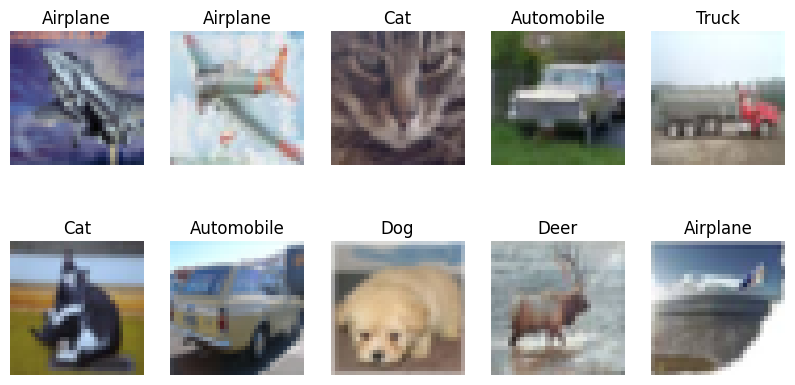

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# CIFAR-10 class names
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Show images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i]
    img = np.transpose(img.numpy(), (1, 2, 0))  # Convert (C, H, W) to (H, W, C)

    ax.imshow(img)
    ax.set_title(classes[labels[i].item()])
    ax.axis("off")

plt.show()

In [ ]:
print("Shape of one image tensor:", images[0].shape)  # Expected: (3, 32, 32)

Shape of one image tensor: torch.Size([3, 32, 32])


## 2️⃣ Model Class

> ***This is a sample architecture, the exact values (of dimensions, shapes, and number of layers) do not match the specific example at hand, but the overall architectural concept still holds.***

![image.png](https://discuss.pytorch.org/uploads/default/optimized/3X/a/7/a71ab512b88e3fc8ec86090ba35acb27c14a659e_2_1035x432.png)

In [ ]:
import torch.nn as nn
import torch

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Activation
        self.relu = nn.ReLU()

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(? * ? * ?, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for CIFAR-10

    def forward(self, x):
        # Convolution + ReLU + Pooling
        # each producing output of the shape (Batch, Channels, Height, Width)

        # Block one:
        x = self.conv1(x) # (?, ?, ?, ?)
        x = self.relu(x) # (?, ?, ?, ?)
        x = self.pool(x) # (?, ?, ?, ?)

        # Block two:
        x = self.pool(self.relu(self.conv2(x)))  # (?, ?, ?, ?)

        # Block three:
        x = self.pool(self.relu(self.conv3(x)))  # (?, ?, ?, ?)

        # Flatten
        x = x.view(x.size(0), -1)  # (?, ?)

        # Fully Connected Layers
        x = self.relu(self.fc1(x))  # (?, ?)
        x = self.fc2(x)  # Logits

        return x                # Although this is a classification problem, we didn't apply softmax. Do you know why?👀 (Hint: CrossEntropyLoss has something to do here👀)

In [ ]:
class AlexNet32(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet32, self).__init__()

        self.features = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 96, kernel_size=11, stride=2, padding=5),  # Output: 96 x 16 x 16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # Output: 96 x 7 x 7

            nn.Conv2d(96, 256, kernel_size=5, padding=2),          # Output: 256 x 7 x 7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # Output: 256 x 3 x 3

            nn.Conv2d(256, 384, kernel_size=3, padding=1),         # Output: 384 x 3 x 3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),         # Output: 384 x 3 x 3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),         # Output: 256 x 3 x 3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1)                   # Output: 256 x 2 x 2
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
            # Do we add Dropout here?
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 3️⃣ Training and Validation Loops

In [ ]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


## 4️⃣ Running Training

In [ ]:
import torch.optim as optim

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 1563/1563 [00:05<00:00, 278.70it/s]


Epoch 1/10: Train Loss=1.5622, Train Accuracy=42.92%, Val Loss=1.3153, Val Accuracy=51.55%


100%|██████████| 1563/1563 [00:05<00:00, 311.67it/s]


Epoch 2/10: Train Loss=1.1943, Train Accuracy=57.12%, Val Loss=1.0707, Val Accuracy=62.22%


100%|██████████| 1563/1563 [00:04<00:00, 328.35it/s]


Epoch 3/10: Train Loss=1.0130, Train Accuracy=64.09%, Val Loss=0.9853, Val Accuracy=65.35%


100%|██████████| 1563/1563 [00:05<00:00, 300.98it/s]


Epoch 4/10: Train Loss=0.9028, Train Accuracy=68.06%, Val Loss=0.9494, Val Accuracy=66.63%


100%|██████████| 1563/1563 [00:05<00:00, 287.02it/s]


Epoch 5/10: Train Loss=0.8263, Train Accuracy=70.89%, Val Loss=0.8877, Val Accuracy=68.94%


100%|██████████| 1563/1563 [00:04<00:00, 322.82it/s]


Epoch 6/10: Train Loss=0.7673, Train Accuracy=73.02%, Val Loss=0.8543, Val Accuracy=70.65%


100%|██████████| 1563/1563 [00:04<00:00, 341.47it/s]


Epoch 7/10: Train Loss=0.7122, Train Accuracy=74.95%, Val Loss=0.8653, Val Accuracy=69.99%


100%|██████████| 1563/1563 [00:04<00:00, 321.74it/s]


Epoch 8/10: Train Loss=0.6633, Train Accuracy=76.74%, Val Loss=0.8716, Val Accuracy=70.02%


100%|██████████| 1563/1563 [00:04<00:00, 339.87it/s]


Epoch 9/10: Train Loss=0.6223, Train Accuracy=77.96%, Val Loss=0.8544, Val Accuracy=71.69%


100%|██████████| 1563/1563 [00:04<00:00, 325.72it/s]


Epoch 10/10: Train Loss=0.5836, Train Accuracy=79.53%, Val Loss=0.9040, Val Accuracy=70.34%


### Plot loss and some predictions

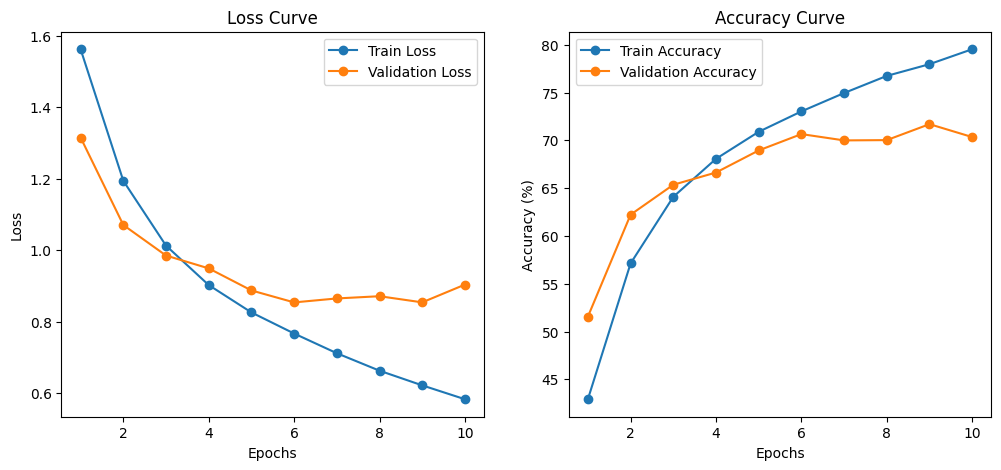

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


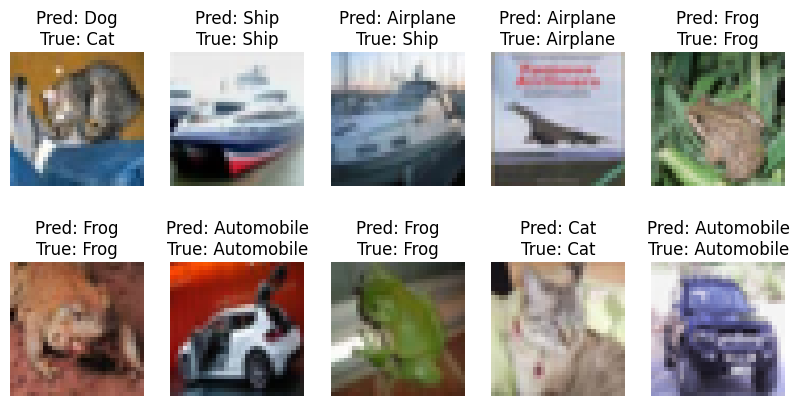

In [ ]:
import numpy as np

# Function to display images with predicted labels
def show_predictions(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)
        predictions = outputs.argmax(dim=1)  # Get predicted class

    # CIFAR-10 class names
    classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat[:num_images]):
        img = images[i]
        img = np.transpose(img.cpu().numpy(), (1, 2, 0))  # Convert to (H, W, C)

        ax.imshow(img)
        ax.set_title(f"Pred: {classes[predictions[i].item()]}\nTrue: {classes[labels[i].item()]}")
        ax.axis("off")

    plt.show()

# Show predictions
show_predictions(model, test_loader, device)


## 4️⃣ Running Training On AlexNet


In [ ]:
import torch.optim as optim

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelAlex = AlexNet32(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(modelAlex.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(modelAlex, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(modelAlex, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 1563/1563 [00:10<00:00, 151.79it/s]


Epoch 1/10: Train Loss=1.7728, Train Accuracy=31.96%, Val Loss=1.4649, Val Accuracy=45.20%


100%|██████████| 1563/1563 [00:10<00:00, 150.64it/s]


Epoch 2/10: Train Loss=1.4235, Train Accuracy=47.96%, Val Loss=1.2504, Val Accuracy=55.13%


100%|██████████| 1563/1563 [00:10<00:00, 150.56it/s]


Epoch 3/10: Train Loss=1.2623, Train Accuracy=54.71%, Val Loss=1.1504, Val Accuracy=59.15%


100%|██████████| 1563/1563 [00:10<00:00, 148.56it/s]


Epoch 4/10: Train Loss=1.1478, Train Accuracy=59.26%, Val Loss=1.0357, Val Accuracy=63.89%


100%|██████████| 1563/1563 [00:10<00:00, 151.19it/s]


Epoch 5/10: Train Loss=1.0605, Train Accuracy=62.67%, Val Loss=1.0885, Val Accuracy=62.32%


100%|██████████| 1563/1563 [00:10<00:00, 150.11it/s]


Epoch 6/10: Train Loss=0.9964, Train Accuracy=65.21%, Val Loss=1.0017, Val Accuracy=65.44%


100%|██████████| 1563/1563 [00:10<00:00, 155.89it/s]


Epoch 7/10: Train Loss=0.9401, Train Accuracy=67.36%, Val Loss=0.9558, Val Accuracy=66.88%


100%|██████████| 1563/1563 [00:10<00:00, 156.06it/s]


Epoch 8/10: Train Loss=0.8992, Train Accuracy=69.02%, Val Loss=0.9781, Val Accuracy=66.44%


100%|██████████| 1563/1563 [00:10<00:00, 145.91it/s]


Epoch 9/10: Train Loss=0.8567, Train Accuracy=70.64%, Val Loss=0.9006, Val Accuracy=69.60%


100%|██████████| 1563/1563 [00:09<00:00, 157.01it/s]


Epoch 10/10: Train Loss=0.8235, Train Accuracy=71.64%, Val Loss=0.9294, Val Accuracy=69.01%


### Plot loss and some predictions

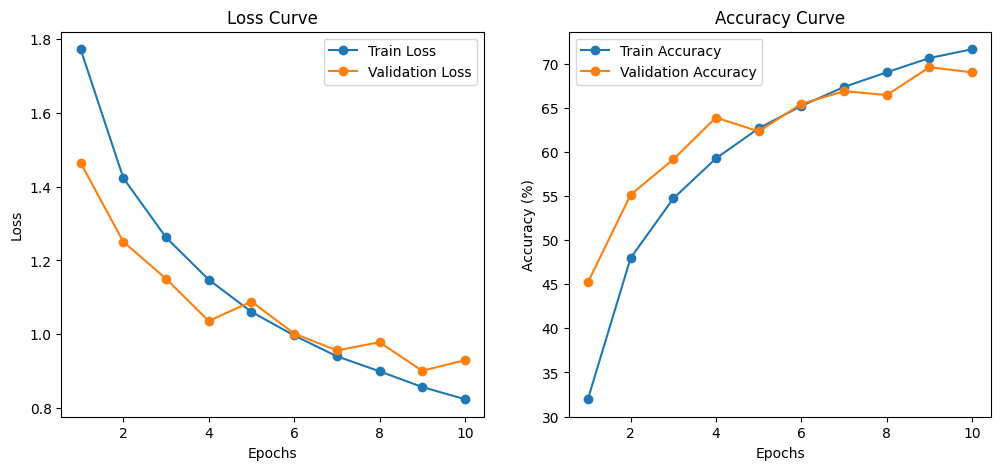

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


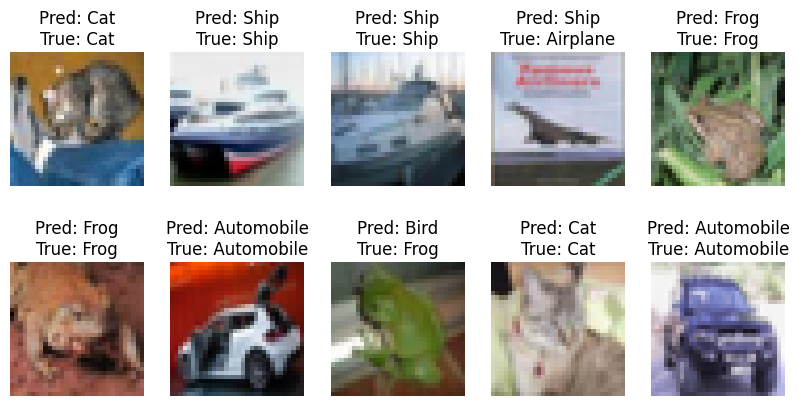

In [ ]:
# Show predictions
show_predictions(modelAlex, test_loader, device)


### Contributed by: Mohamed Eltayeb & Ali Habibullah

![image.png](https://i.imgur.com/a3uAqnb.png)